## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse

import matplotlib.pyplot as plt

In [2]:
DATAFILE = '../ad_campaign_data.csv' # location of dataset
random_state = None # change to something for exactly reproducible results

# as selected in "tutorial_bias_advertising" notebook
selected_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated', 'homeowner']
cate_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated']
num_features = ['homeowner']

# if not specified, set to 1
feature_weights = {"gender": 1, "parents": 1, "age": 1}

target_name = "true_conversion"
positive_label = 1
negative_label = 0

model_train_fraction = 0.7
learning_class_weights = {0: 0.5, 1: 265}

sensitive_attribute = "gender"
sensitive_subgroups = ["M", "F"]
sensitive_alias = {"Male": "M", "Female": "F"}

## Load Dataset

In [3]:
ad_conversion_dataset = pd.read_csv(DATAFILE)
ad_conversion_dataset.head()

,religion,politics,college_educated,parents,homeowner,gender,age,income,area,true_conversion,predicted_conversion,predicted_probability
0,Unknown,Unknown,1,1,1,Unknown,55-64,Unknown,Unknown,0,0,0.001351
1,Other,Unknown,1,1,1,Unknown,55-64,Unknown,Urban,0,0,0.002238
2,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.002704
3,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.001967
4,Unknown,Unknown,1,1,1,F,55-64,Unknown,Urban,0,0,0.001681


### Print some statistics for the dataset

In [4]:
print(f"Number of (instances, attributes) in the dataset = {ad_conversion_dataset.shape}")
print()

print(f"Statistics of true conversions (0=no, 1=yes)")
print(ad_conversion_dataset.true_conversion.value_counts())
print()

print(f"Statistics of predicted conversions (0=no, 1=yes)")
print(ad_conversion_dataset.predicted_conversion.value_counts())

Number of (instances, attributes) in the dataset = (1443140, 12)

Statistics of true conversions (0=no, 1=yes)
0    1440766
1       2374
Name: true_conversion, dtype: int64

Statistics of predicted conversions (0=no, 1=yes)
0    1440773
1       2367
Name: predicted_conversion, dtype: int64


### Warning!

There is no model!

Predictions (from whatever model has been used) have been incorporated into the dataset, in the columns "predicted_conversion" (which is the predicted label) and "predicted_probability" (which is the predicted probability of belonging to the positive class).

Moreover, the dataset is highly unbalanced, and this is also evident in the poor efficiency of the model, as demonstrated in the confusion matrix below.

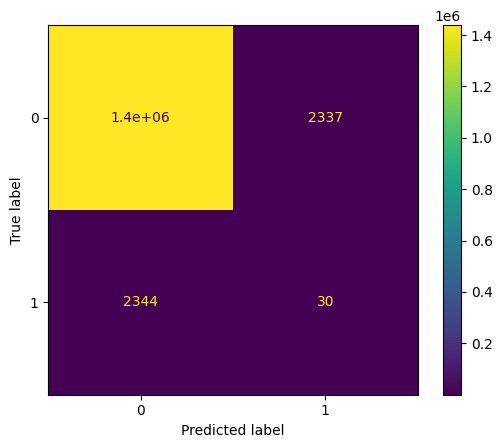

In [5]:
conf_matrix = confusion_matrix(ad_conversion_dataset.true_conversion, ad_conversion_dataset.predicted_conversion)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Preprocessing

In [6]:
## keep only the columns in selected_features, plus the label column
ad_conversion_dataset = ad_conversion_dataset[selected_features + [target_name]]
ad_conversion_dataset

,gender,parents,age,income,area,college_educated,homeowner,true_conversion
0,Unknown,1,55-64,Unknown,Unknown,1,1,0
1,Unknown,1,55-64,Unknown,Urban,1,1,0
2,F,1,55-64,Unknown,Unknown,1,1,0
3,F,1,55-64,Unknown,Unknown,1,1,0
4,F,1,55-64,Unknown,Urban,1,1,0
...,...,...,...,...,...,...,...,...
1443135,F,1,25-34,Unknown,Unknown,1,1,0
1443136,F,1,55-64,Unknown,Unknown,1,0,0
1443137,Unknown,1,55-64,Unknown,Unknown,1,1,0
1443138,F,1,55-64,Unknown,Unknown,1,1,0


In [7]:
## train-test split

X = ad_conversion_dataset.drop(target_name, axis=1)
y = ad_conversion_dataset[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=model_train_fraction, random_state=random_state, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Model training

In [8]:
%%time

model = customLogisticRegression(class_weight=learning_class_weights)
model.fit(X_train, y_train, cate_columns=cate_features, target_column=target_name)
model.predict(X_test.iloc[:100, :])

CPU times: total: 23.4 s
Wall time: 7.34 s


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Testing the model

We check if the model is satisfactory.

In [9]:
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    432231
           1       0.00      0.06      0.00       712

    accuracy                           0.95    432943
   macro avg       0.50      0.51      0.49    432943
weighted avg       1.00      0.95      0.97    432943



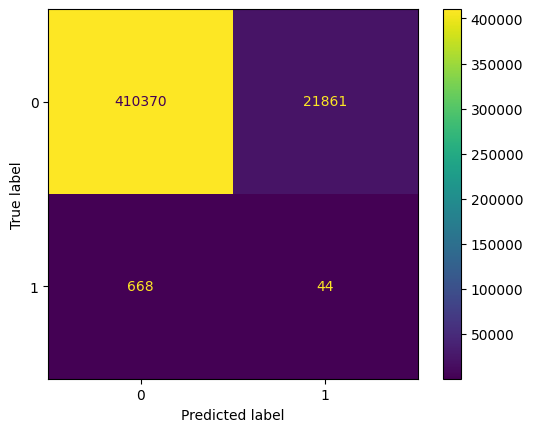

In [10]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

Given the high imbalance of the dataset, we consider that the above results, for a simple logistic regression, are good enough.

# Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [11]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model,
    sensitive_attribute,
    missing_subgroup_val="Unknown"
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

100%|████████████████████████████████████████████████████████████████████████████████| 520/520 [00:52<00:00,  9.82it/s]

Number of if-thens: 520


Uncomment the following block if you wish to load rules object from disk.

In [12]:
# import dill

# with open("rules.data", "rb") as inf:
#     rules_by_if = dill.load(inf)

In [13]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["M"][1][0][1]-e[1]["F"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If homeowner = 0, parents = 1, age = 55-64, income = Unknown:
	Subgroup 'F', 8.7620% covered
		Make income = >100K with correctness 100.0000%.
		Make income = <100K with correctness 0.0000%.
		Make age = 45-54, income = >100K with correctness 100.0000%.
	Subgroup 'M', 8.8924% covered
		Make income = >100K with correctness 0.0000%.
		Make income = <100K with correctness 0.0000%.
		Make age = 45-54, income = >100K with correctness 100.0000%.
If parents = 1, age = 55-64, homeowner = 0, income = <100K, area = Unknown:
	Subgroup 'F', 1.1560% covered
		Make income = >100K with correctness 100.0000%.
	Subgroup 'M', 1.1710% covered
		Make income = >100K with correctness 0.0000%.
If homeowner = 0, parents = 1, age = 55-64, income = <100K:
	Subgroup 'F', 1.1560% covered
		Make income = >100K with correctness 100.0000%.
		Make income = Unknown with correctness 0.0000%.
		Make age = 45-54, income = >100K with correctness 100.0000%.
	Subgroup 'M', 1.1710% covered
		Make income = >100K with correctn

In [14]:
# #### Uncomment if you wish to save rules object on disk

# import dill

# with open("rules.data", "wb") as outf:
#     dill.dump(rules_by_if, outf)

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [15]:
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [51]:
top_rules = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top_rules.keys()), list(top_rules.values()))
))

If homeowner = 1, age = 55-64, area = Unknown, income = <100K:
	Subgroup 'F', 1.2260% covered out of 600135
		Make homeowner = 0, income = >100K with correctness 94.2423%.
		Make homeowner = 0, age = 25-34 with correctness 94.2423%.
		Aggregate cost of the above recourses = 1.88485
	Subgroup 'M', 1.2250% covered out of 314181
		Make homeowner = 0, income = >100K with correctness 0.0000%.
		Make homeowner = 0, age = 25-34 with correctness 0.0000%.
		Aggregate cost of the above recourses = 0.0
If college_educated = 1, parents = 1, age = 55-64, homeowner = 0, income = <100K:
	Subgroup 'F', 1.0944% covered out of 600135
		Make income = >100K with correctness 100.0000%.
		Make college_educated = 0, income = >100K with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.5
	Subgroup 'M', 1.1032% covered out of 314181
		Make income = >100K with correctness 0.0000%.
		Make college_educated = 0, income = >100K with correctness 0.0000%.
		Aggregate cost of the above recourses = 0.0

## Minimum cost above threshold

In [52]:
top_rules = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top_rules.keys()),
        list(top_rules.values()),
        group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
        cor_thres=0.5
    )
))

If homeowner = 0, income = Unknown:
	Subgroup 'F', 9.7339% covered out of 600135
		Make income = >100K with correctness 91.6807%.
		Aggregate cost of the above recourses = 1.0
	Subgroup 'M', 9.8623% covered out of 314181
		Aggregate cost of the above recourses = inf
If homeowner = 0, parents = 1, income = Unknown:
	Subgroup 'F', 9.2003% covered out of 600135
		Make income = >100K with correctness 96.9863%.
		Aggregate cost of the above recourses = 1.0
	Subgroup 'M', 9.3318% covered out of 314181
		Aggregate cost of the above recourses = inf
If homeowner = 0, college_educated = 1, income = Unknown:
	Subgroup 'F', 9.1980% covered out of 600135
		Make income = >100K with correctness 91.6749%.
		Make college_educated = 0, income = >100K with correctness 91.6749%.
		Aggregate cost of the above recourses = 1.0
	Subgroup 'M', 9.3223% covered out of 314181
		Aggregate cost of the above recourses = inf
If homeowner = 0, parents = 1, college_educated = 1, income = Unknown:
	Subgroup 'F', 8.6960%

## Cost above threshold

In [54]:
top_rules = gfacts.select_rules_subset(
    rules_by_if,
    metric="total-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top_rules.keys()),
        list(top_rules.values()),
        group_calculator=gfacts.if_group_cost_sum_change_correctness_threshold,
        cor_thres=0.5
    )
))

If homeowner = 0, income = Unknown:
	Subgroup 'F', 9.7339% covered out of 600135
		Make income = >100K with correctness 91.6807%.
		Aggregate cost of the above recourses = 1.0
	Subgroup 'M', 9.8623% covered out of 314181
		Aggregate cost of the above recourses = inf
If homeowner = 0, parents = 1, income = Unknown:
	Subgroup 'F', 9.2003% covered out of 600135
		Make income = >100K with correctness 96.9863%.
		Aggregate cost of the above recourses = 1.0
	Subgroup 'M', 9.3318% covered out of 314181
		Aggregate cost of the above recourses = inf
If homeowner = 0, college_educated = 1, income = Unknown:
	Subgroup 'F', 9.1980% covered out of 600135
		Make income = >100K with correctness 91.6749%.
		Make college_educated = 0, income = >100K with correctness 91.6749%.
		Aggregate cost of the above recourses = 3.0
	Subgroup 'M', 9.3223% covered out of 314181
		Aggregate cost of the above recourses = inf
If homeowner = 0, parents = 1, college_educated = 1, income = Unknown:
	Subgroup 'F', 8.6960%

## Number above threshold

In [55]:
top_rules = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top_rules.keys()),
        list(top_rules.values()),
        group_calculator=gfacts.if_group_cost_recoursescount_correctness_threshold,
        cor_thres=0.5
    )
))

If homeowner = 0, age = 55-64, income = Unknown:
	Subgroup 'F', 9.2601% covered out of 600135
		Make income = >100K with correctness 94.6213%.
		Make age = 25-34 with correctness 94.6213%.
		Make age = 25-34, income = <100K with correctness 94.6213%.
		Make age = 45-54, income = >100K with correctness 94.7799%.
		Make age = 25-34, income = >100K with correctness 94.7799%.
		Aggregate cost of the above recourses = 5.0
	Subgroup 'M', 9.3911% covered out of 314181
		Make age = 25-34 with correctness 94.6900%.
		Make age = 45-54, income = >100K with correctness 94.7351%.
		Make age = 25-34, income = >100K with correctness 94.8253%.
		Aggregate cost of the above recourses = 3.0
If homeowner = 0, college_educated = 1, income = Unknown:
	Subgroup 'F', 9.1980% covered out of 600135
		Make income = >100K with correctness 91.6749%.
		Make college_educated = 0, income = >100K with correctness 91.6749%.
		Aggregate cost of the above recourses = 2.0
	Subgroup 'M', 9.3223% covered out of 314181
		Ag

# Experimentation with cumulative correctness plots for each rule

First, load state

In [56]:
import dill

with open("state.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

In [57]:
test_if = gfacts.Predicate.from_dict({"area": "Unknown", "age": "45-54"})

thens = rules_by_if[test_if]

thens

{'F': (0.014086470524868356,
  [(Predicate(features=['area', 'age'], values=['Unknown', '55-64']),
    0.16464237516869096),
   (Predicate(features=['area', 'age'], values=['Urban', '55-64']),
    0.2136752136752137),
   (Predicate(features=['area', 'age'], values=['Urban', '25-34']),
    0.9581646423751687),
   (Predicate(features=['area', 'age'], values=['Unknown', '25-34']),
    0.16464237516869096)]),
 'M': (0.01805976083432731,
  [(Predicate(features=['area', 'age'], values=['Unknown', '55-64']),
    0.15410668924640136),
   (Predicate(features=['area', 'age'], values=['Urban', '55-64']),
    0.9576629974597799),
   (Predicate(features=['area', 'age'], values=['Urban', '25-34']),
    0.9576629974597799),
   (Predicate(features=['area', 'age'], values=['Unknown', '25-34']),
    0.15410668924640136)])}

In [58]:
gender = "F"
gfacts.cumcorr(test_if, thens[gender][1], X_test[(model.predict(X_test) == 0) & (X_test.gender == gender)], model)

cumcorrs=array([0.16464238, 0.16464238, 0.21367521, 0.95816464])


[(Predicate(features=['area', 'age'], values=['Unknown', '55-64']),
  0.16464237516869096,
  1.0),
 (Predicate(features=['area', 'age'], values=['Unknown', '25-34']),
  0.16464237516869096,
  1.0),
 (Predicate(features=['area', 'age'], values=['Urban', '55-64']),
  0.21367521367521367,
  2.0),
 (Predicate(features=['area', 'age'], values=['Urban', '25-34']),
  0.9581646423751687,
  2.0)]

Text(0, 0.5, 'Correctness percentage')

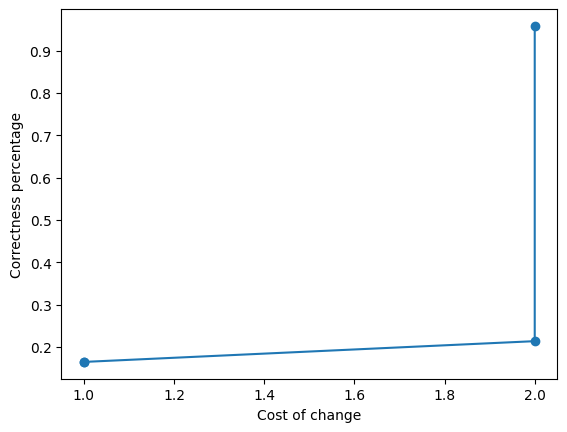

In [59]:
costs = [1, 1, 2, 2]
correctnesses = np.array([0.16464238, 0.16464238, 0.21367521, 0.95816464])

fig, ax = plt.subplots()
ax.plot(costs, correctnesses, marker="o")
ax.set_xlabel("Cost of change")
ax.set_ylabel("Correctness percentage")

Finally, save state

In [44]:
# import dill

with open("state.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)